In [8]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
options(repr.matrix.max.rows = 6)

<h2>Introduction</h2> 

<h4>Background Information</h4>  

We are interested in what player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how these  
features differ between various player types. Specifically, we are interested in if **a player's total playtime and age can predict if that player is  
subscribed to a game-related newsletter or not**. In order to carry out our analysis, we must load the data in and make changes to the data so that it  
is formatted appropriately. This also allows us to properly visualize the data which helps us navigate through our analysis as well as convey information.  
With the properly formatted data and the information provided by the visualizations, we can perform the data analysis. More specifically, we  
will be able to create an algorithm that tries to categorize if a player is subscribed to a game-related newsletter based on total playtime and age.  
This algorithm can be trained and tested and its accuracy will help us come to a conclusion. Additional visualizations will help convey the reasoning  
behind our conclusion.

<h4>Data Description</h4>

Datasets provided for the analysis are **sessions.csv** and **players.csv**

Dataset **sessions.csv** contains data for unique play sessions including the session start and end times and a string unique to each player.  
The columns in this data set are:
1. **hashedEmail**: string variable unique for the player
2. **start_time**: character variable indicating date and time of start of session
3. **end_time**: character variable indicating date and time of end of session
4. **original_start_time**: numeric variable indicating start time of session in unknown format
5. **original_end_time**: numeric variable indicating end time of session in unknown format

Dataset **players.csv** contains data for each unique player including personal and game-related information.  
The columns in this data set are:
1. **experience**: categorical variable stating the experience level of the player
2. **subscribe**: boolean variable stating if the player is subscribed to a game-related newsletter
3. **hashedEmail**: string variable unique for the player
4. **played_hours**: numeric variable stating total hours played for the player
5. **name**: string variable stating the name of the player
6. **gender**: string variable stating the gender of the player
7. **Age**: numeric variable stating the age of the player

It should be noted that dataset **sessions.csv** is unnecessary for our analysis, so will not be referred to here on out.

<h2>Methods & Results</h2>

<h4>Data Wrangling</h4>

As stated in the introduction, the data needs to be formatted appropriately. This process is referred to as wrangling  
and is carried out here:

In [9]:
players <- read_csv("https://raw.githubusercontent.com/Kqvii/DSCI100-Group13/refs/heads/main/data/players.csv") |>
    mutate(subscribe = as_factor(subscribe)) |> # Turning TRUE and FALSE into two unique categories
    filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe)) # Removes lines of data which contain NA values as they will interfere with the analysis
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [10]:
players_wrangled <- players |> 
    select(subscribe, played_hours, Age) # Isolating the columns required for our analysis

<h4>Exploratory Visualizations</h4>

In order to better understand the data we are working with, we will create visualizations using the wrangled data here:

subscribe,subscribed,average_hours_played
<fct>,<int>,<dbl>
FALSE,52,0.5019231
TRUE,142,7.8830986


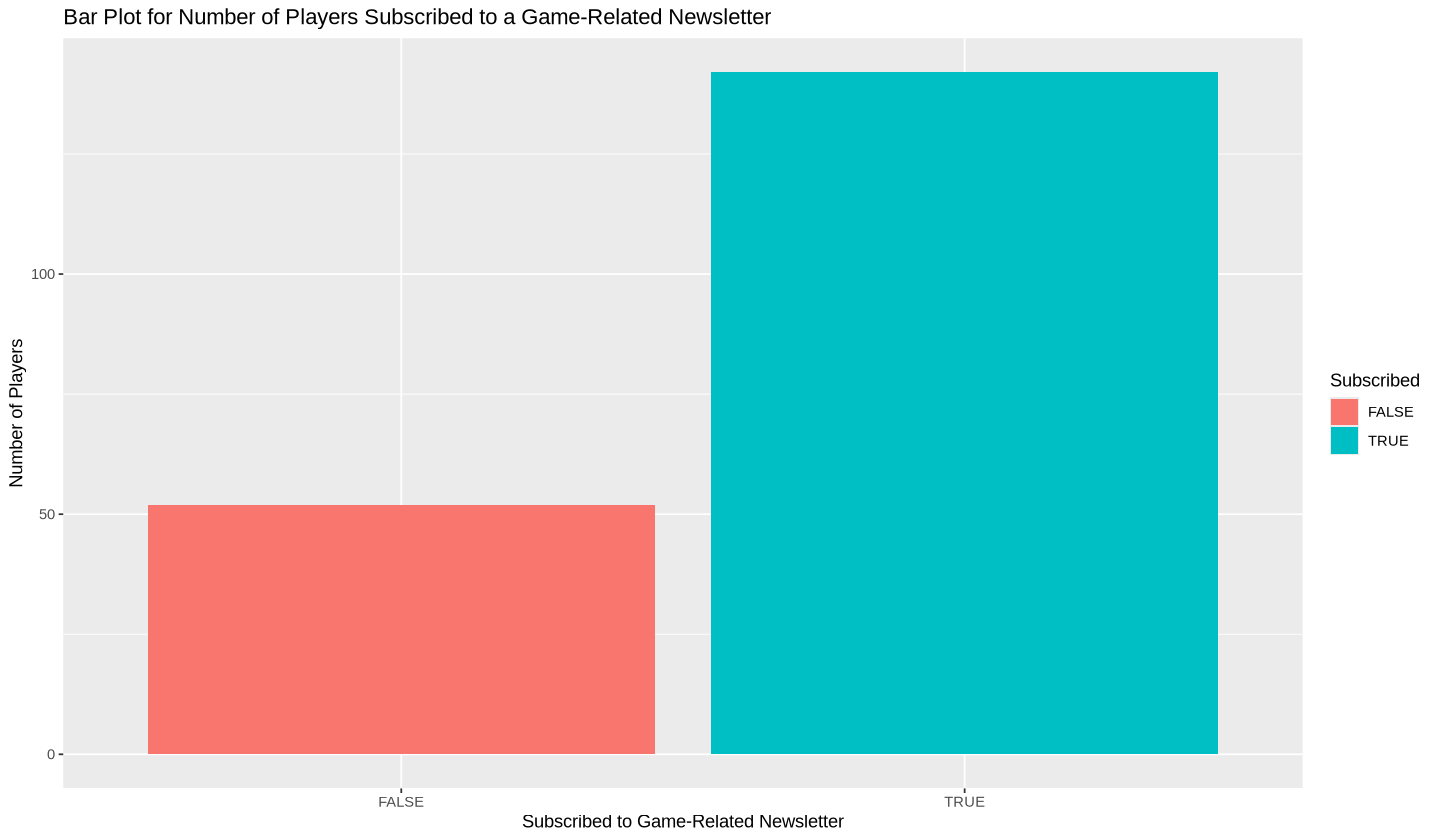

In [25]:
subscribed_viz_data <- players_wrangled |>
    group_by(subscribe) |> # Grouping observations by subscripton status
    summarize(subscribed = n(), # Counts number of observations based on subscription status
              average_hours_played = mean(played_hours)) # Determines average total playtime based on subscription status
subscribed_viz_data

subscribed_viz <- subscribed_viz_data |>
    ggplot(aes(x = subscribe, y = subscribed, fill = subscribe)) +
        geom_bar(stat='identity') +
        labs(x = "Subscribed to Game-Related Newsletter",
             y = "Number of Players",
             title = "Bar Plot for Number of Players Subscribed to a Game-Related Newsletter",
             fill = "Subscribed")
subscribed_viz

We see that in the entire dataset, there is a much greater proportion of players who are subscribed to  
a game-related newsletter rather than not. As well, we see that the average total playtime for those  
subscribed appears to be higher. This means that a relationship between total playtime and subscription  
status may exist and is worth analyzing.

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


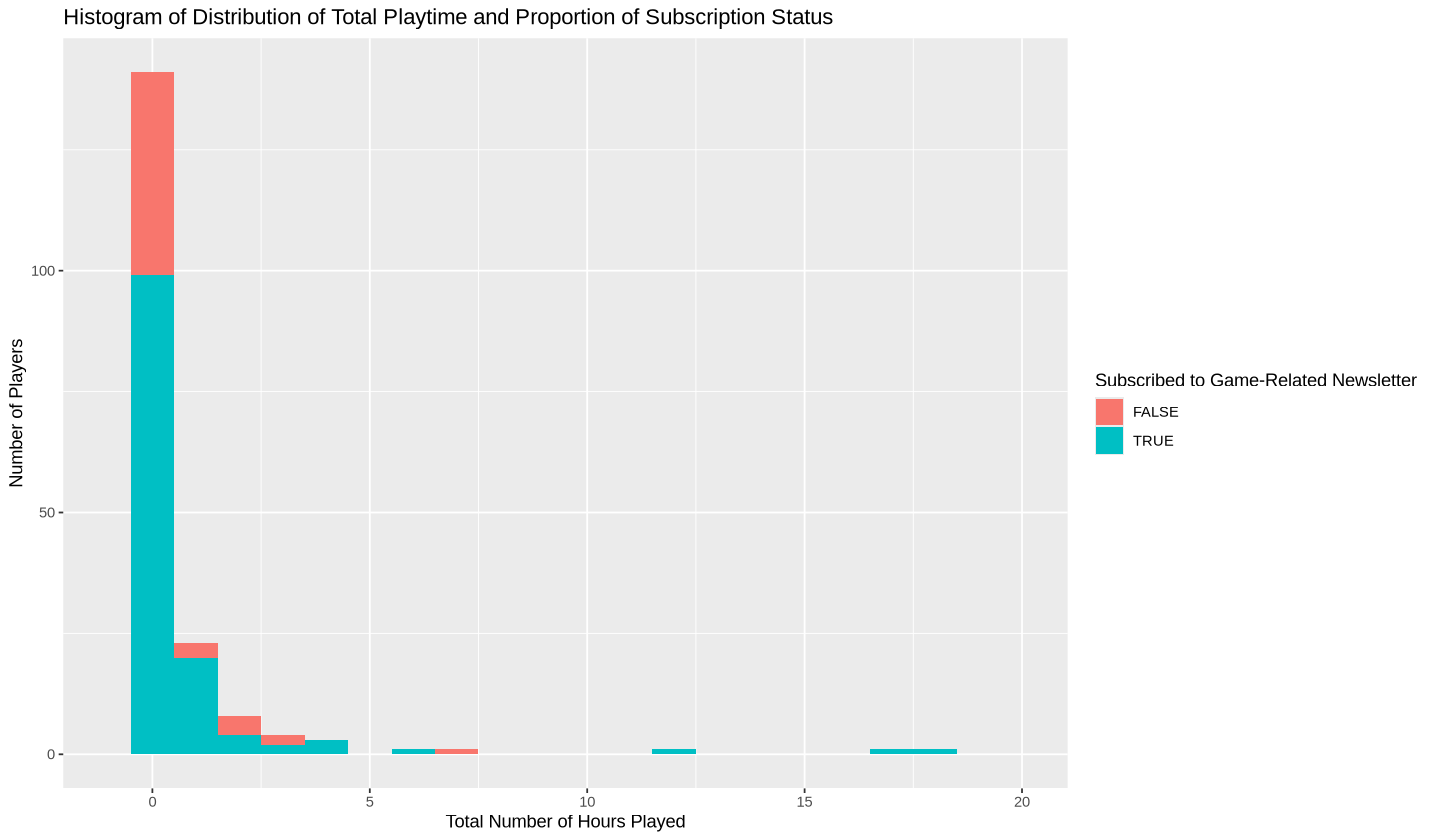

In [26]:
players_dist <- players_wrangled |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 1) +
    scale_x_continuous(limits = c(-1, 20)) +
    labs(x = "Total Number of Hours Played", 
         y = "Number of Players",
         title = "Histogram of Distribution of Total Playtime and Proportion of Subscription Status",
         fill = "Subscribed to Game-Related Newsletter")

players_dist

Here we can better visualize the proportion of subscription status based on the distribution of total playtime.  
It does appear that for longer total playtimes, the player may be more likely to subscribe.

subscribe,Age
<fct>,<dbl>
TRUE,9
TRUE,17
FALSE,17
⋮,⋮
FALSE,22
FALSE,17
FALSE,17


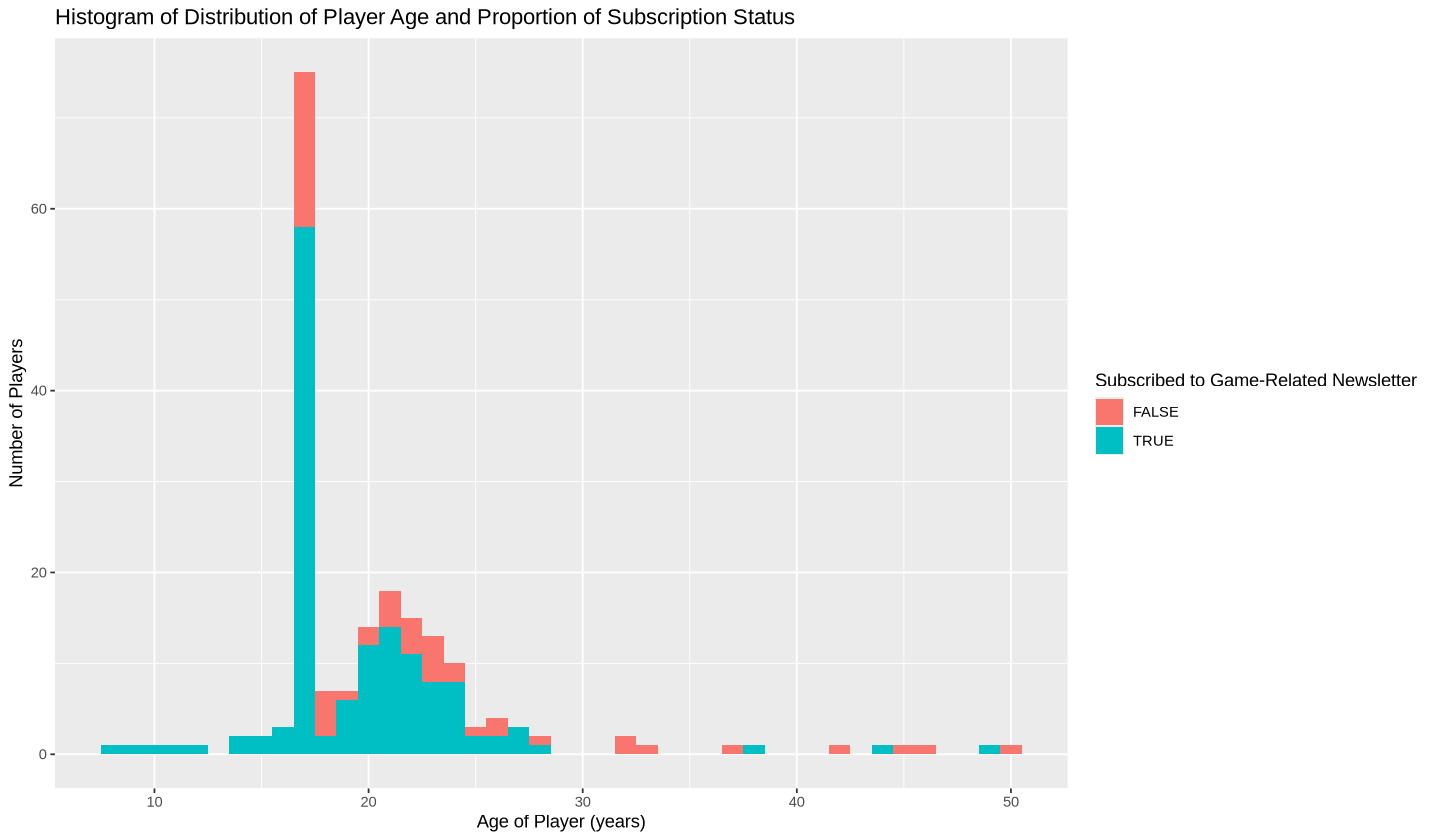

In [18]:
options(repr.plot.width = 12)

age_viz_data <- players_wrangled |>
    select(subscribe, Age)
age_viz_data

age_viz <- age_viz_data |>
    ggplot(aes(x = Age, fill = subscribe)) +
        geom_histogram(binwidth = 1) +
        labs(x = "Age of Player (years)",
             y = "Number of Players",
             title = "Histogram of Distribution of Player Age and Proportion of Subscription Status",
             fill = "Subscribed to Game-Related Newsletter")
age_viz

This visualization shows that there are varying proportions of players subscribed to a game-related newsletter  
based on age. There appears to be a higher proportion of being subscribed for younger ages instead of older  
ages. This means that a relationship between age and subscription status may exist and is worth analyzing as well.

<h4>Model Building and Initial Data Analysis</h4>

Now that we believe that total playtime and age may be predictive of subscription status, we can begin our analysis.  
To begin building our predictive model, we must separate the data into training and testing sets. We do this so that  
we can train our model using the training data and test its accuracy using the testing set. If we were to train our  
model using all the data, it would be untestable, and thus its accuracy would be unquantifiable. Since the training  
and testing sets are randomly chosen, we have to ensure the same random sets are chosen across different machines  
otherwise our analysis will be inconsistent.

In [43]:
set.seed(1234) # Ensures reproducibility by keeping the random choice consistent

players_split <- initial_split(players_wrangled, prop = 0.75, strata = subscribe)  # Sets 75% to training and 25% to testing
players_train <- training(players_split)   
players_test <- testing(players_split)

players_train
players_test

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,21
FALSE,0.0,22
FALSE,0.1,17
⋮,⋮,⋮
TRUE,0,17
TRUE,0,20
TRUE,0,17


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
FALSE,0.0,17
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.1,17
TRUE,0.1,44
FALSE,2.3,17


Now that we have our training and testing data sets, we can build our predictive model. We need to specify  
what we are trying to predict and what we are using to generate the prediction (predictors). As well, we  
need to ensure that the predictors are contributing equally to our predictions. We are using a k-nearest  
neighbours algorithm which predicts based on distance, so scaling and centering the predictors is crucial.

In [44]:
subscribe_recipe <- recipe(subscribe ~ played_hours + Age, data = players_wrangled) |> # Setting predictors to total playtime and age to predict subscription status
  step_center(all_predictors()) |>  # Centers the predictors (mean set to 0)
  step_scale(all_predictors()) # Scales the predictors (standard deviation to 1)

subscribe_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |> # Setting model to use distance between the 9 nearest points in its predictive calculations
      set_engine("kknn") |> # Setting engine to k-nearest neighbours
      set_mode("classification") # Setting the method of prediction to categorize its prediction into TRUE or FALSE subscription status

subscribe_fit <- workflow() |>
      add_recipe(subscribe_recipe) |>
      add_model(subscribe_model) |>
      fit(data = players_train) # Combining the prediction settings and model specifications and applying it to the training data

We have now applied the predictive model to the training data, which we refer to as fitting, so that the  
model is trained. This means the model is now prepared to classify the subscription status of new observations  
based on age and total playtime.

In [45]:
players_predictions <- predict(subscribe_fit, players_test) |> # Applying our trained model to the testing data
    bind_cols(players_test) # Adding the column of predictions to the testing data so that we can compare

players_predictions

players_predictions_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) # Calculating the accuracy by dividing the correct predictions (matches) by the incorrect predictions (unmatched)

players_predictions_metrics

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,30.3,9
FALSE,FALSE,0.0,17
TRUE,TRUE,0.1,21
⋮,⋮,⋮,⋮
TRUE,TRUE,0.1,17
FALSE,TRUE,0.1,44
TRUE,FALSE,2.3,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5714286
kap,binary,-0.0729927


After testing our model on the testing data, we see that the accuracy is quite low at 57%. While we could  
draw conclusions about our hypothesis from this, we must take into account that our model is not fully  
optimized yet. When initially creating our model, we set our model to use the 9 nearest points in its  
predictive calculations. Before drawing any conclusions, we must first optimize our model so that it is  
as accurate as possible and only then can we begin to draw conclusions.

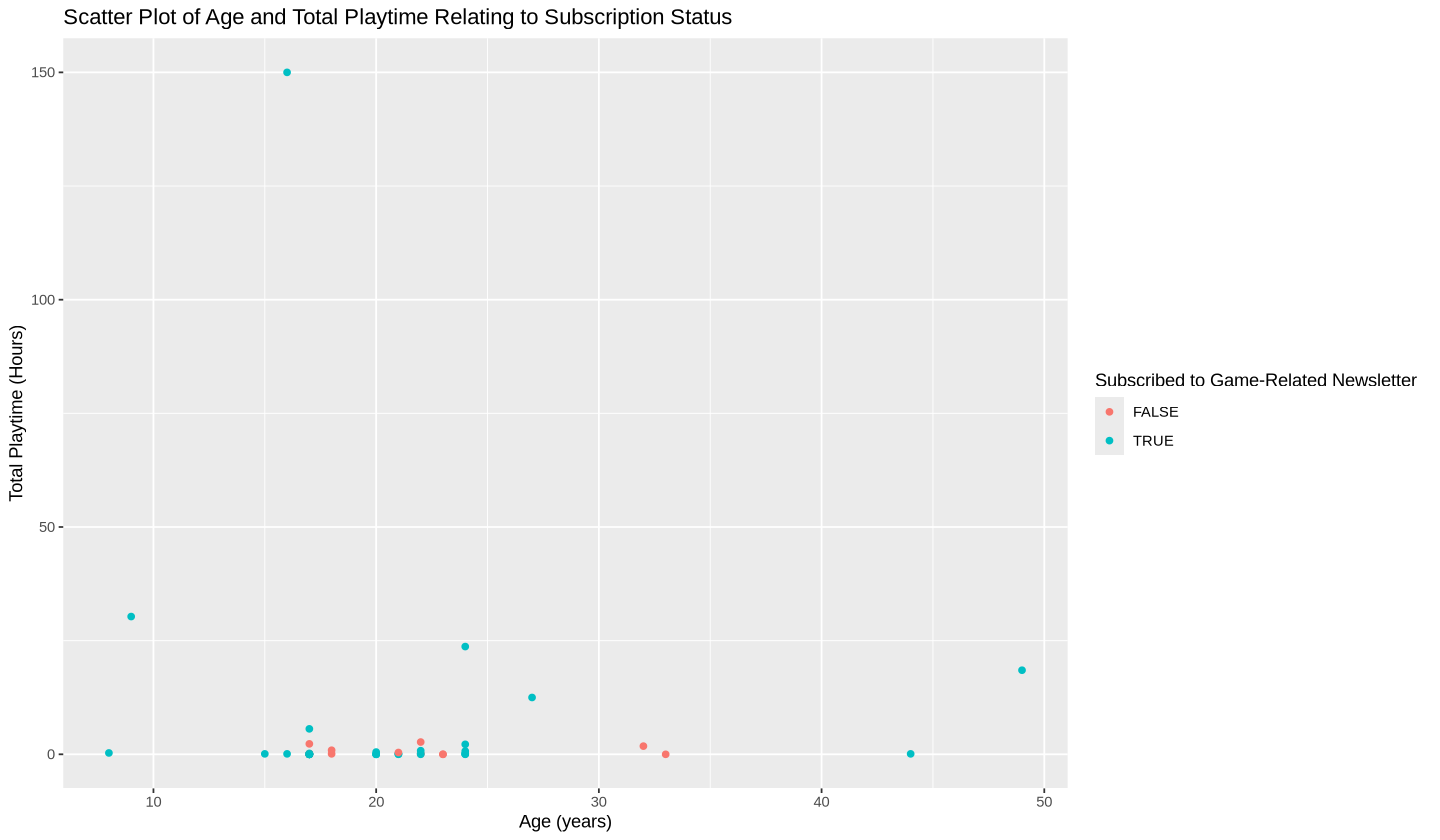

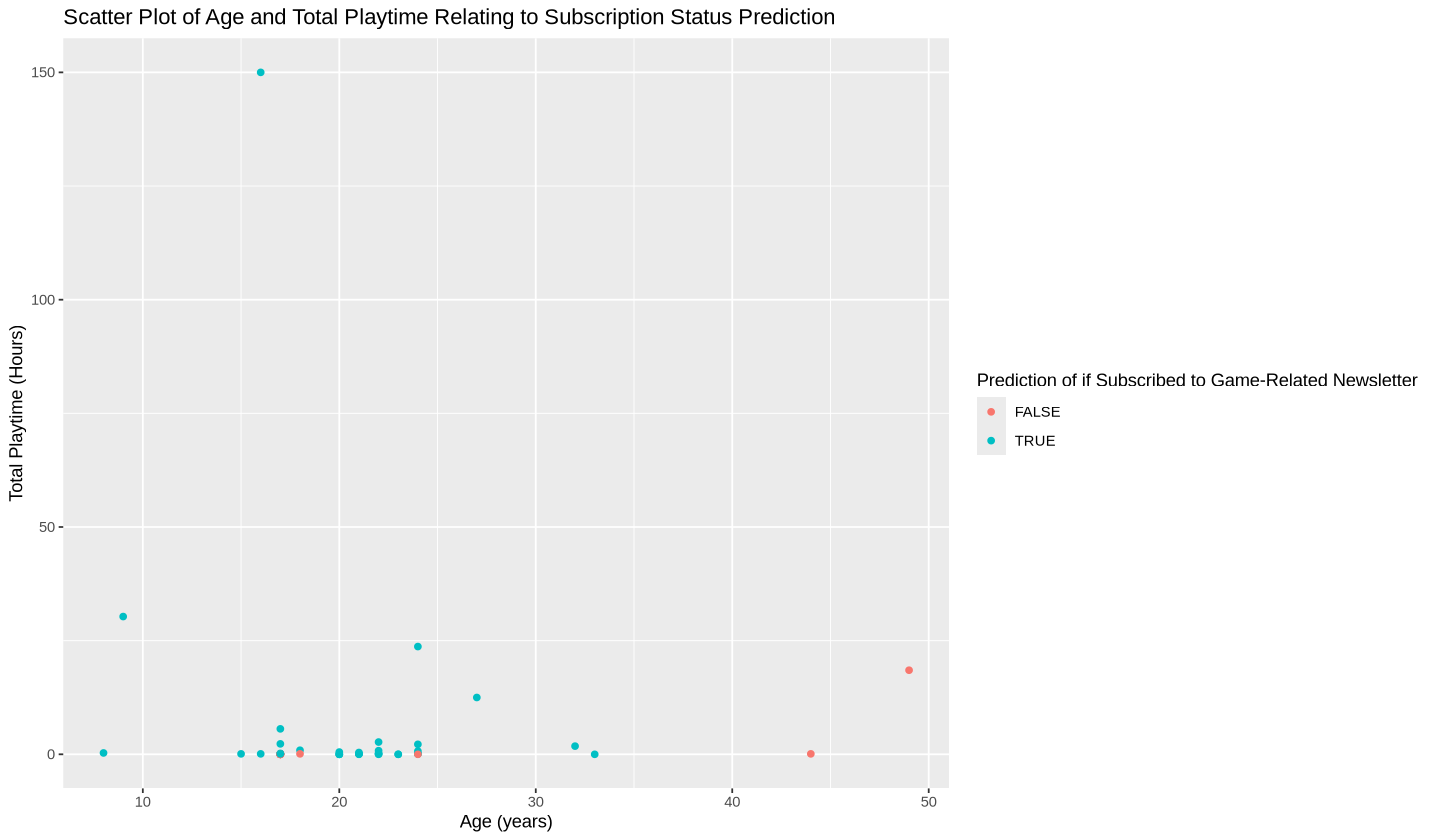

In [46]:
players_plot <- players_predictions |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        xlab("Age (years)") + 
        ylab("Total Playtime (Hours)") +
        labs(colour = "Subscribed to Game-Related Newsletter",
             title = "Scatter Plot of Age and Total Playtime Relating to Subscription Status")
players_plot


players_prediction_plot <- players_predictions |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = .pred_class)) +
        xlab("Age (years)") + 
        ylab("Total Playtime (Hours)") +
        labs(colour = "Prediction of if Subscribed to Game-Related Newsletter",
             title = "Scatter Plot of Age and Total Playtime Relating to Subscription Status Prediction")
players_prediction_plot

Here is a visual comparison of the testing data (top graph) and our model's predictions (bottom graph). We see  
that there are quite a few points that are classified incorrectly, notably the 4 rightmost points.

In [47]:
average_player <- players_wrangled |>
    summarize(avg_age = median(Age),
              avg_playtime = median(played_hours))
average_player

new_obs <- tibble(played_hours = 0.1,Age =19)
class_prediction <- predict(subscribe_fit, new_obs)
class_prediction

avg_age,avg_playtime
<dbl>,<dbl>
19,0.1


.pred_class
<fct>
TRUE


Here we see that the average player is predicted to be subscribed to a game-related newsletter

<h4>Model Optimization and Final Data Analysis</h4>

As stated previously, we must optimize our model before drawing conclusions, specifically optimizing the  
value of k. To do so, we will first split the training data further into 5 sets. 4 of these sets will be  
assigned to be training sets, and the 1 remaining set will be assigned to be the validation set. Out of  
the initial 5 sets, we can shuffle which sets are the training sets, and which 1 is the validation set.  
Each unique combination of the training and validation sets are referred to as folds and in our case of  
the initial split into 5 sets, we will have 5 folds. This allows us to perform cross-validation where  
our model is trained and tested (referred to as validated) across the folds which should afford a model  
with higher accuracy (due to more training).

In [48]:
subscribe_vfold <- vfold_cv(players_train, v = 5, strata = subscribe) # Splitting training data into the 5 fold

players_resample_fit <- workflow() |> 
  add_recipe(subscribe_recipe) |>   
  add_model(subscribe_model) |>       
  fit_resamples(resamples = subscribe_vfold) # Applying our model to the folds, performing cross-validation

players_metrics <- collect_metrics(players_resample_fit) |> # Collecting statistics of cross-validation
    filter(.metric == "accuracy")
players_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6333662,5,0.0327461,Preprocessor1_Model1


Here we see that performing cross-validation did indeed increase the accuracy of our model from 57% to  
63.3%. We can now begin optimizing our k value.

In [49]:
players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> # Indicating to the model to allow varying k values
    set_engine("kknn") |>
    set_mode("classification")

players_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [52]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1)) # Setting the k values we want to test as integers from 1 to 10

knn_results <- workflow() |> 
  add_recipe(subscribe_recipe) |> 
  add_model(players_tune) |>
  tune_grid(resamples = subscribe_vfold, grid = k_vals) |>  # Applying model with the set k values to the cross-validation
  collect_metrics()  # Collecting results of cross-validation
                 
accuracies <- knn_results |> 
    filter(.metric == "accuracy") |> # Filtering results for accuracy metric only
    select(neighbors, mean) |> # Selecting columns of accuracy and k
    arrange(-mean) # Sort k in descending accuracy
accuracies

neighbors,mean
<dbl>,<dbl>
7,0.6409688
8,0.6338424
9,0.6333662
⋮,⋮
3,0.5243842
1,0.4889327
2,0.4889327


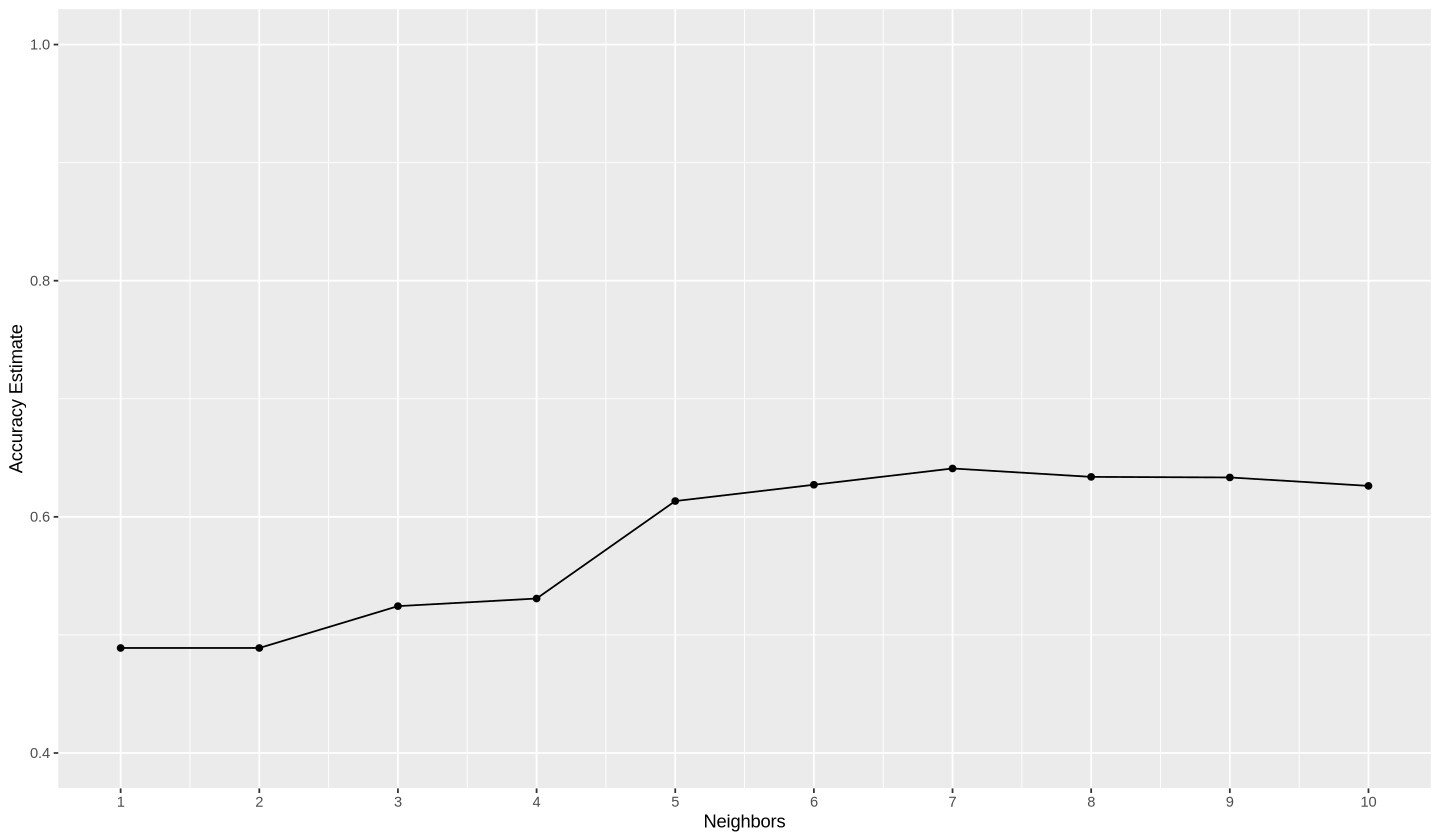

In [51]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

Now we see that out of the k values from 1 to 10, the k value of 7 gives the highest accuracy for the model of 64%. We  
are now finished with the analysis of the data and can begin discussing our findings to come to draw conclusions.

<h2>Discussion</h2>

<h4>Summary</h4>

When we began our data wrangling and visualization, we chose to investigate the factors affecting the likelihood of a player   
to subscribe. With the caveat that the small sample size of less than 200 may not be representative of the entire population,  
these are the three main conclusions we drew.  

As the first bar plot shows, a significantly greater number of players (142) are subscribed to the newsletter while only a small  
minority (52) are not. This demonstrates a meaningful relationship between engagement with Plaicraft and their likelihood to  
subscribe to a game-related newsletter. This suggests a strong interest in game-related content among the player base.  

The second bar plot evaluates the relationship between playtime and the likelihood one is subscribed to a game-related newsletter.  
While the amount of observations with a higher playtime is low and should be taken with a grain of salt, there does seem to be a  
correlation between time invested into the game and one’s likelihood to subscribe. In fact, there is no player with a playtime  
above 10 hours that is not subscribed.
    
The third bar plot shows the positive relationship between a player being younger and their likelihood to subscribe. Above the  
age of 30, there are more players that are not subscribed than those are subscribed, but this reverses dramatically among those  
under the age of 30. In particular, every player who is still in middle school is subscribed. 

To evaluate the predictive power of these relationships, we employed a K-Nearest Neighbors (KNN) classification model. A k-value of  
7 yielded the highest accuracy, but the model's predictive performance topped out at just 64%. This relatively modest accuracy  
indicates that while there is some signal in the data, it is not strong enough to draw firm conclusions or build a reliable predictive  
tool based solely on the available features. Other unmeasured factors  such as motivation, interests, or promotional exposure may play  
a significant role in a player’s decision to subscribe as well.

<h4>Expectations vs. Reality</h4>

While it is impossible to be fully confident of our conclusions given the middling predictive performance and relatively small sample  
size, the data displayed in the graphs largely correlates with our guiding hypothesis that a higher playtime and a lower age would be  
correlated with a subscription to the game-related newsletter. This is because we expected that higher playtime would correlate with  
a wider interest in information relating to the game, and that being younger meant more free time to devote to the game and related  
information. In a way, both of these factors reinforce each other. 

<h4>Impact of Findings</h4>

These findings have potential implications for game developers, server administrators, and marketers in the videogame ecosystem. Our  
graphs indicate the existence of a core audience for game-related content that skews younger and has more free time to sink into games  
like Plaicraft. Newsletters could serve as a powerful channel for communicating with this group, and server owners would be wise to offer  
sneak peaks at upcoming content, exclusive in-game rewards, or even early access to new features. Minecraft servers would be wise to  
reach out to younger players through such an avenue.  

From a business perspective, the observed drop in newsletter subscription among older players also raises a question: should game companies  
invest in retaining aging players or focus on bringing in a steady stream of new, younger players? The current data, though limited, points  
toward the latter being a more fruitful path. Younger players not only have more free time but are also more likely to immerse themselves  
in the culture surrounding the game, including newsletters, communities, and updates. This could imply that a steady series of partnerships  
with content creators could be a good way to appeal to new younger audiences, and would be more effective than trying to retain older users  
who may be aging out of Plaicraft’s target demographic.

<h4>Future Questions this could Lead to</h4>

These results also raise important questions for future research. First, it is unclear whether newsletter subscription is merely a reflection  
of engagement or a contributing factor to it. Further investigation, ideally with longitudinal data, would help determine whether subscribing  
to a newsletter leads to increased playtime and retention, or whether the most engaged players are simply more inclined to subscribe in the  
first place. Additionally, the content of the newsletter itself warrants closer analysis: does it appeal to different age groups equally, or  
is it catered to younger players? Understanding this could lead to more personalized communication strategies, possibly segmented by age or  
playstyle.
